In [15]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sns
import pandas as pd
import os 
import gc

# Initialize the lists
label = []
path = []

# Set the dataset directory path
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'

for dir_name, _, filenames in os.walk(fish_dir):
    # Pass directories that includes'GT' 
    if 'GT' not in dir_name:
        for filename in filenames:
            if os.path.splitext(filename)[-1] == '.png':  
                label.append(os.path.split(os.path.dirname(dir_name))[-1])
                
                path.append(os.path.join(dir_name, filename))
            
            
# Create a DataFrame to store image paths and labels
data = pd.DataFrame(columns=['path', 'label'])
data['path'] = path
data['label'] = label

                                                path            label
0  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
1  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
2  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
3  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
4  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB
None



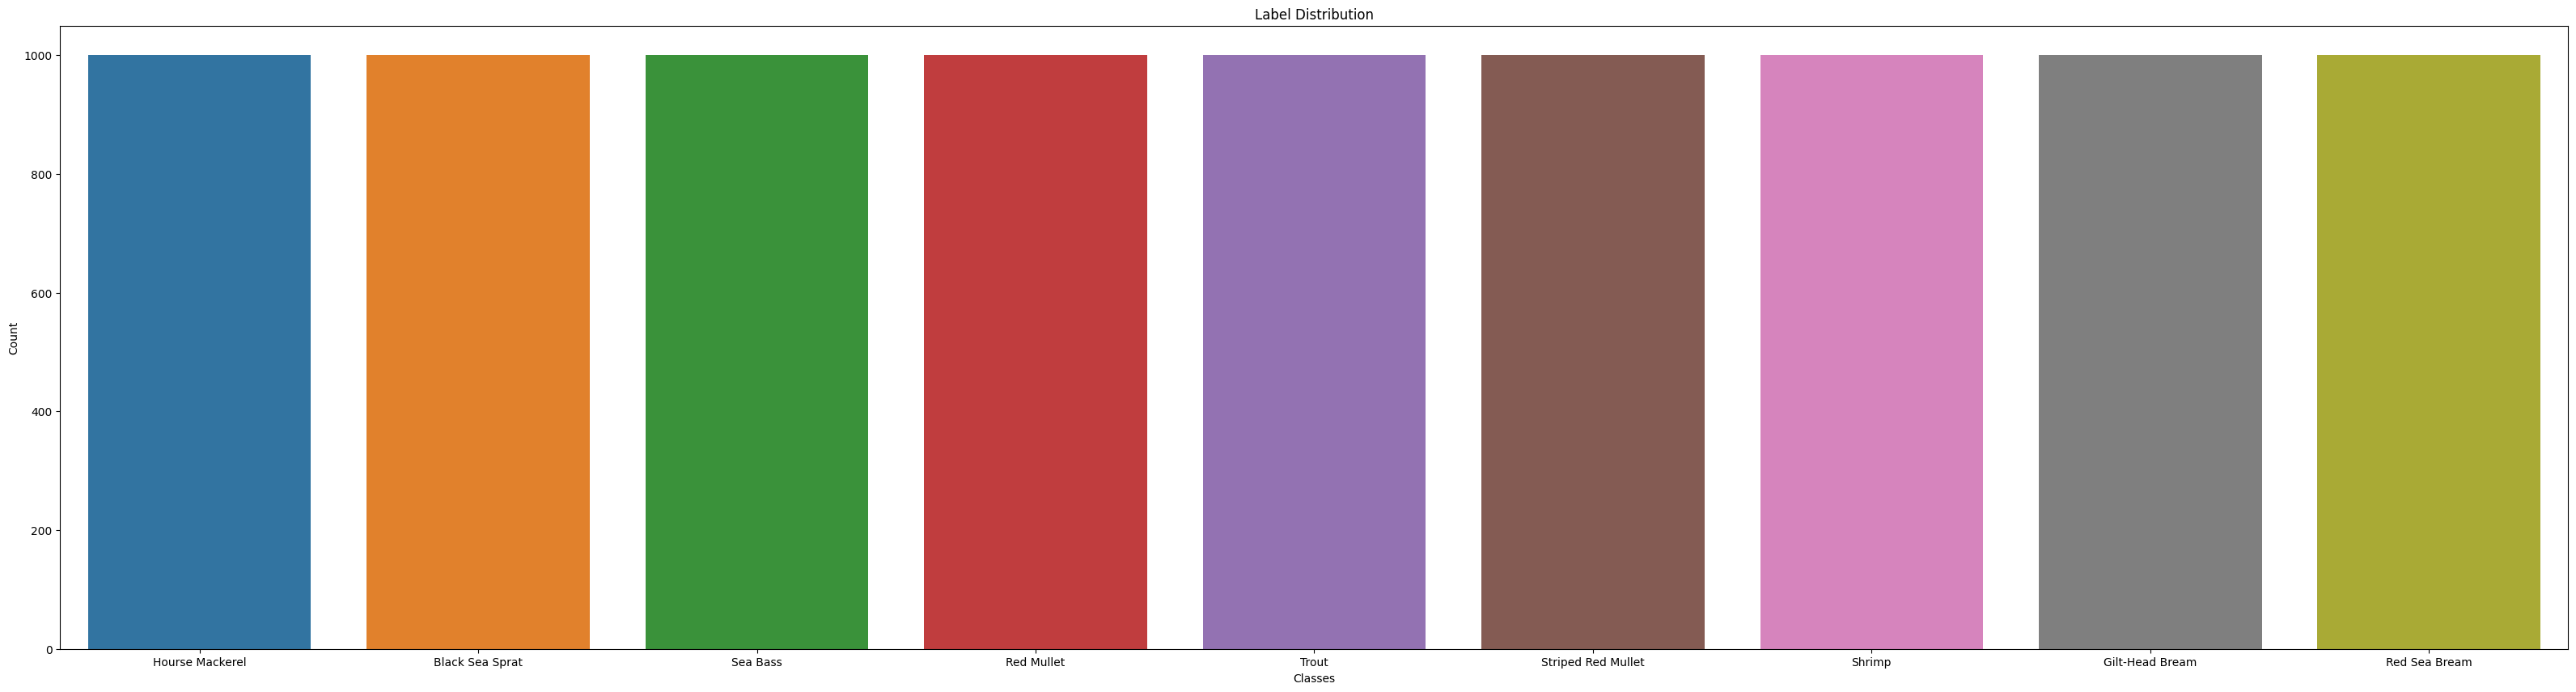

In [16]:
# Display the first few rows of the DataFrame
print(f"{data.head()}\n")

# General Information about dataset
print(f"{data.info()}\n")

# Class Distribution of labels
plt.figure(figsize=(40, 10))
sns.countplot(x=data['label'])
plt.title('Label Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

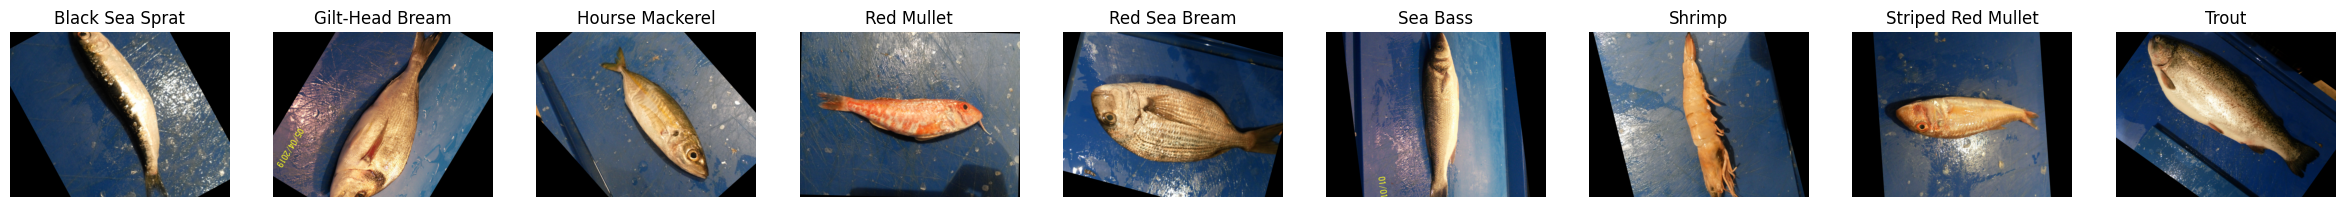

In [18]:
# Find unique classes
unique_classes = np.unique(data['label'])

fig, axes = plt.subplots(1, len(unique_classes), figsize=(30, 10))  

for i, class_label in enumerate(unique_classes):
    class_indices = np.where(data['label'] == class_label)[0]
    first_index = class_indices[0]  

    img_path = data['path'][first_index]
    img = Image.open(img_path)
    
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"{class_label}")  

plt.show()

In [19]:
from multiprocessing import Pool
import cv2

img_size=(192, 192)    

# Function to load and resize images
def load_and_preprocess_image(image_path, target_size=img_size):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)  # Resize image to the target size
    img_array = np.array(img) # Convert image to numpy array
    
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
    # Apply adaptive thresholding
    binary_mask = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY, 9, 3)
    # Use the binary mask to highlight the fish
    masked_image = cv2.bitwise_and(img_array, img_array, mask=binary_mask)
    
    return masked_image

In [20]:
# Parallel image loading
def parallel_load_and_preprocess(image_paths):
    with Pool() as pool:
        image_data = pool.map(load_and_preprocess_image, image_paths)
    return np.array(image_data)

In [4]:
# Preprocess data
image_data = parallel_load_and_preprocess(data['path'])

In [5]:
# Normalize data
image_data = (image_data / 255.0) - 0.32

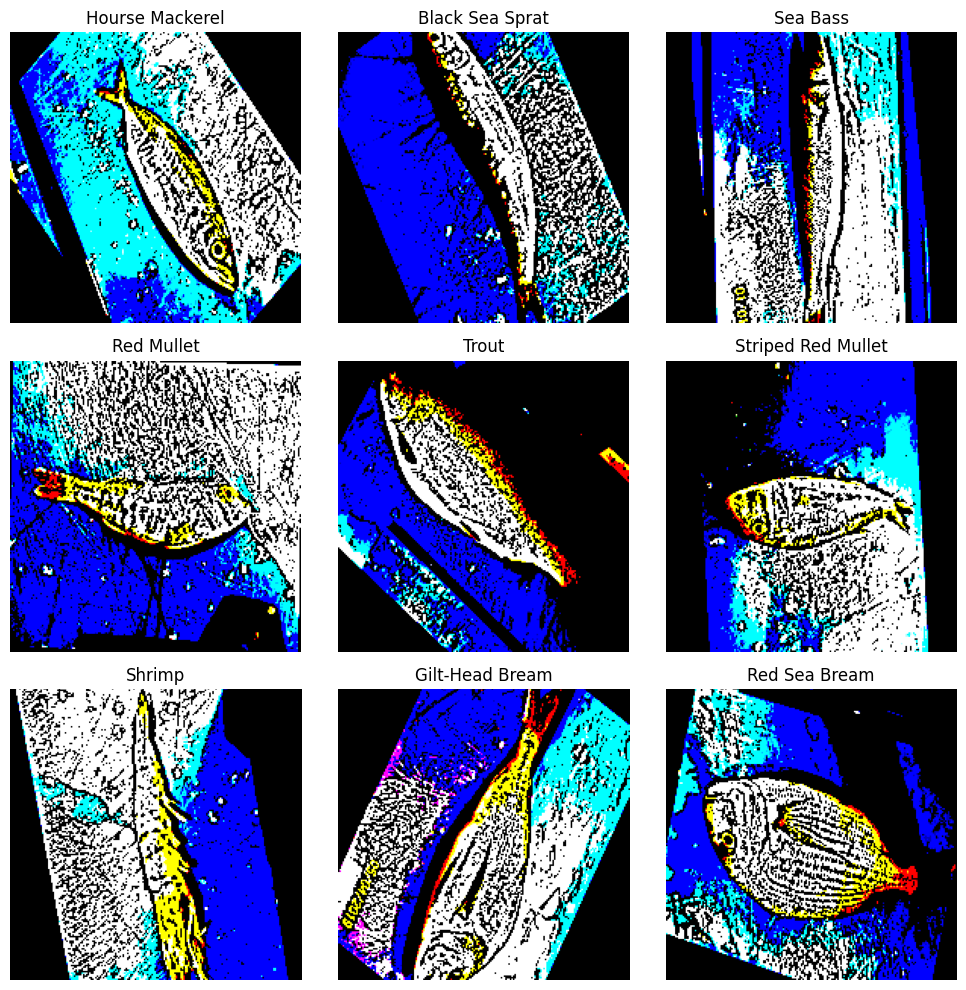

In [18]:
# Show first 5 preprocessed images

plt.figure(figsize=(10, 10))

for idx, i in enumerate(range(0, len(image_data), 1000)):
    ax = plt.subplot(3, 3, idx + 1)  
    ax.imshow((image_data[i] * 255.0) + 0.32)  
    
    ax.set_title(f"{data['label'][i]}")  
    ax.axis('off')  

plt.tight_layout()  
plt.show()

In [6]:
from sklearn.preprocessing import LabelEncoder

# Converting categorical labels to numerical
le = LabelEncoder()
data['label_encoded'] = le.fit_transform(data['label'])

print("Class -> Encoded Value\n")
for cls, encoded_cls in zip(le.classes_, data['label_encoded'].unique()):
    print(f"{cls} : {encoded_cls}")

Class -> Encoded Value

Black Sea Sprat : 2
Gilt-Head Bream : 0
Hourse Mackerel : 5
Red Mullet : 3
Red Sea Bream : 8
Sea Bass : 7
Shrimp : 6
Striped Red Mullet : 1
Trout : 4


In [10]:
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore")

print(f"Image data: {image_data.shape}")

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(image_data, data['label_encoded'], test_size=0.15, random_state=42)

print(f"X_train: {X_train.shape}")
print(f"y_train: {len(y_train)}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {len(y_test)}")

gc.collect()

Image data: (9000, 192, 192, 3)
X_train: (7650, 192, 192, 3)
y_train: 7650
X_test: (1350, 192, 192, 3)
y_test: 1350


20579

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

print(f"X_train: {X_train.shape}")
print(f"y_train: {len(y_train)}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {len(y_val)}\n")

# Define the model
model = Sequential()

model.add(Flatten(input_shape=(192, 192, 3)))

model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))  

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))  

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))  

model.add(Dense(len(le.classes_), activation='softmax'))

# Compile the model using Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Model training parameters
batch_size = 32
epochs = 100

# Define the Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (validation loss)
    patience=5,          # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore the best weights after stopping
)

# Train the model using the data generators
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    callbacks=[early_stopping]
)

X_train: (6502, 192, 192, 3)
y_train: 6502
X_val: (1148, 192, 192, 3)
y_val: 1148
Epoch 1/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - accuracy: 0.1890 - loss: 3.0557 - val_accuracy: 0.5070 - val_loss: 1.4683
Epoch 2/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.3405 - loss: 2.1587 - val_accuracy: 0.6254 - val_loss: 1.1421
Epoch 3/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.4087 - loss: 1.8854 - val_accuracy: 0.6664 - val_loss: 1.0133
Epoch 4/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.4723 - loss: 1.6531 - val_accuracy: 0.7073 - val_loss: 0.9083
Epoch 5/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5002 - loss: 1.5221 - val_accuracy: 0.7474 - val_loss: 0.8094
Epoch 6/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5454 - loss: 1.3201 - val_accuracy: 0.7683 - val_loss: 0.7555
Epoch 7/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5818 - loss: 1.2552 - val_accuracy: 0.7840 - val_loss: 0.6957
Epoch 8

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9113 - loss: 0.3017
Test Accuracy: 0.914814829826355
Test Loss: 0.28556811809539795


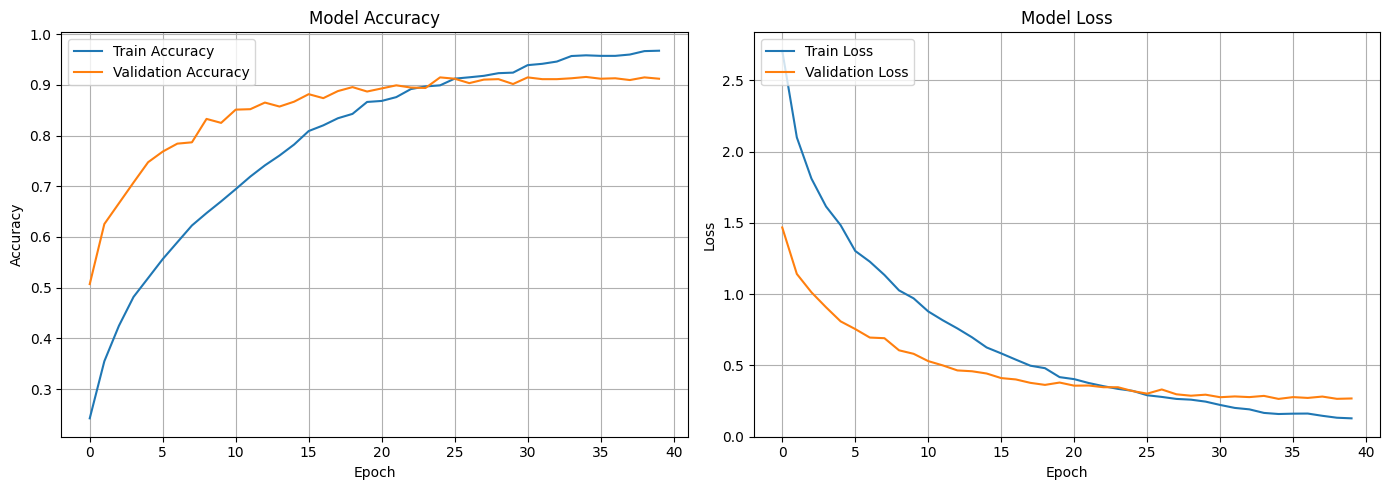

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


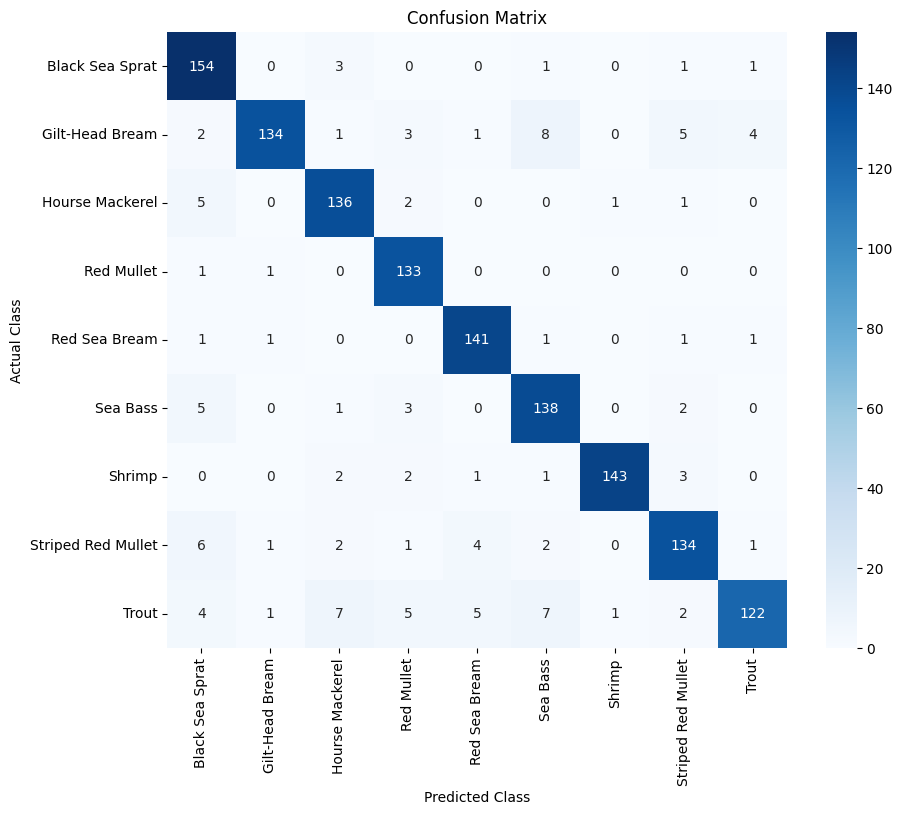

Classification Report:
                    precision    recall  f1-score   support

   Black Sea Sprat       0.87      0.96      0.91       160
   Gilt-Head Bream       0.97      0.85      0.91       158
   Hourse Mackerel       0.89      0.94      0.92       145
        Red Mullet       0.89      0.99      0.94       135
     Red Sea Bream       0.93      0.97      0.95       146
          Sea Bass       0.87      0.93      0.90       149
            Shrimp       0.99      0.94      0.96       152
Striped Red Mullet       0.90      0.89      0.89       151
             Trout       0.95      0.79      0.86       154

          accuracy                           0.91      1350
         macro avg       0.92      0.92      0.91      1350
      weighted avg       0.92      0.91      0.91      1350

The model does not appear to be overfitting.


In [12]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

# 1. Plotting the loss and accuracy over epochs
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function to plot the accuracy and loss
plot_training_history(history)

# 2. Confusion Matrix
# Get the predicted labels
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# 3. Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

# 4. Checking for Overfitting
# Overfitting occurs when the training loss is significantly lower than the validation loss
# or when the training accuracy is significantly higher than the validation accuracy.

train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

if (train_acc - val_acc > 0.1) and (train_loss < val_loss):
    print("The model is likely overfitting, as the training accuracy is much higher than validation accuracy and training loss is much lower than validation loss.")
else:
    print("The model does not appear to be overfitting.")
